<a href="https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/05_TS_archs_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importer les bibliothèques  📚

In [5]:
# # **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
stable = True # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.5.1 which is incompatible.


In [6]:
from tsai.all import *
import matplotlib.pyplot as plt


os              : Linux-6.1.123+-x86_64-with-glibc2.35
python          : 3.11.12
tsai            : 0.4.0
fastai          : 2.7.19
fastcore        : 1.7.29
torch           : 2.5.1+cu124
device          : 1 gpu (['Tesla T4'])
cpu cores       : 1
threads per cpu : 2
RAM             : 12.67 GB
GPU memory      : [15.0] GB


# Entrainement des models 🧪

,arch,hyperparams,train loss,valid loss,accuracy
0,InceptionTime,{},0.017568,0.114440,0.960814
1,LSTM_FCN,{},0.404213,0.346391,0.905852
2,FCN,{},0.632577,0.646581,0.855471
3,LSTM,{},1.895900,1.993620,0.353181
4,RNN,{},2.274829,2.359964,0.239695


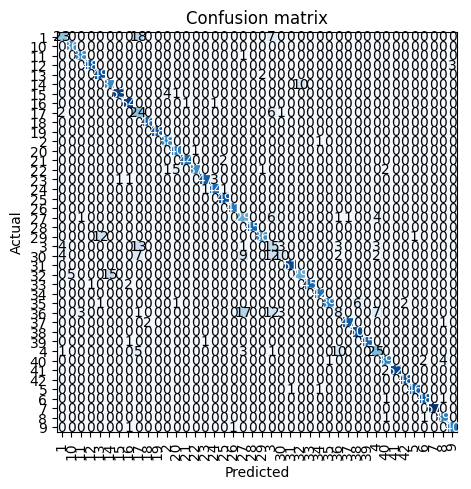

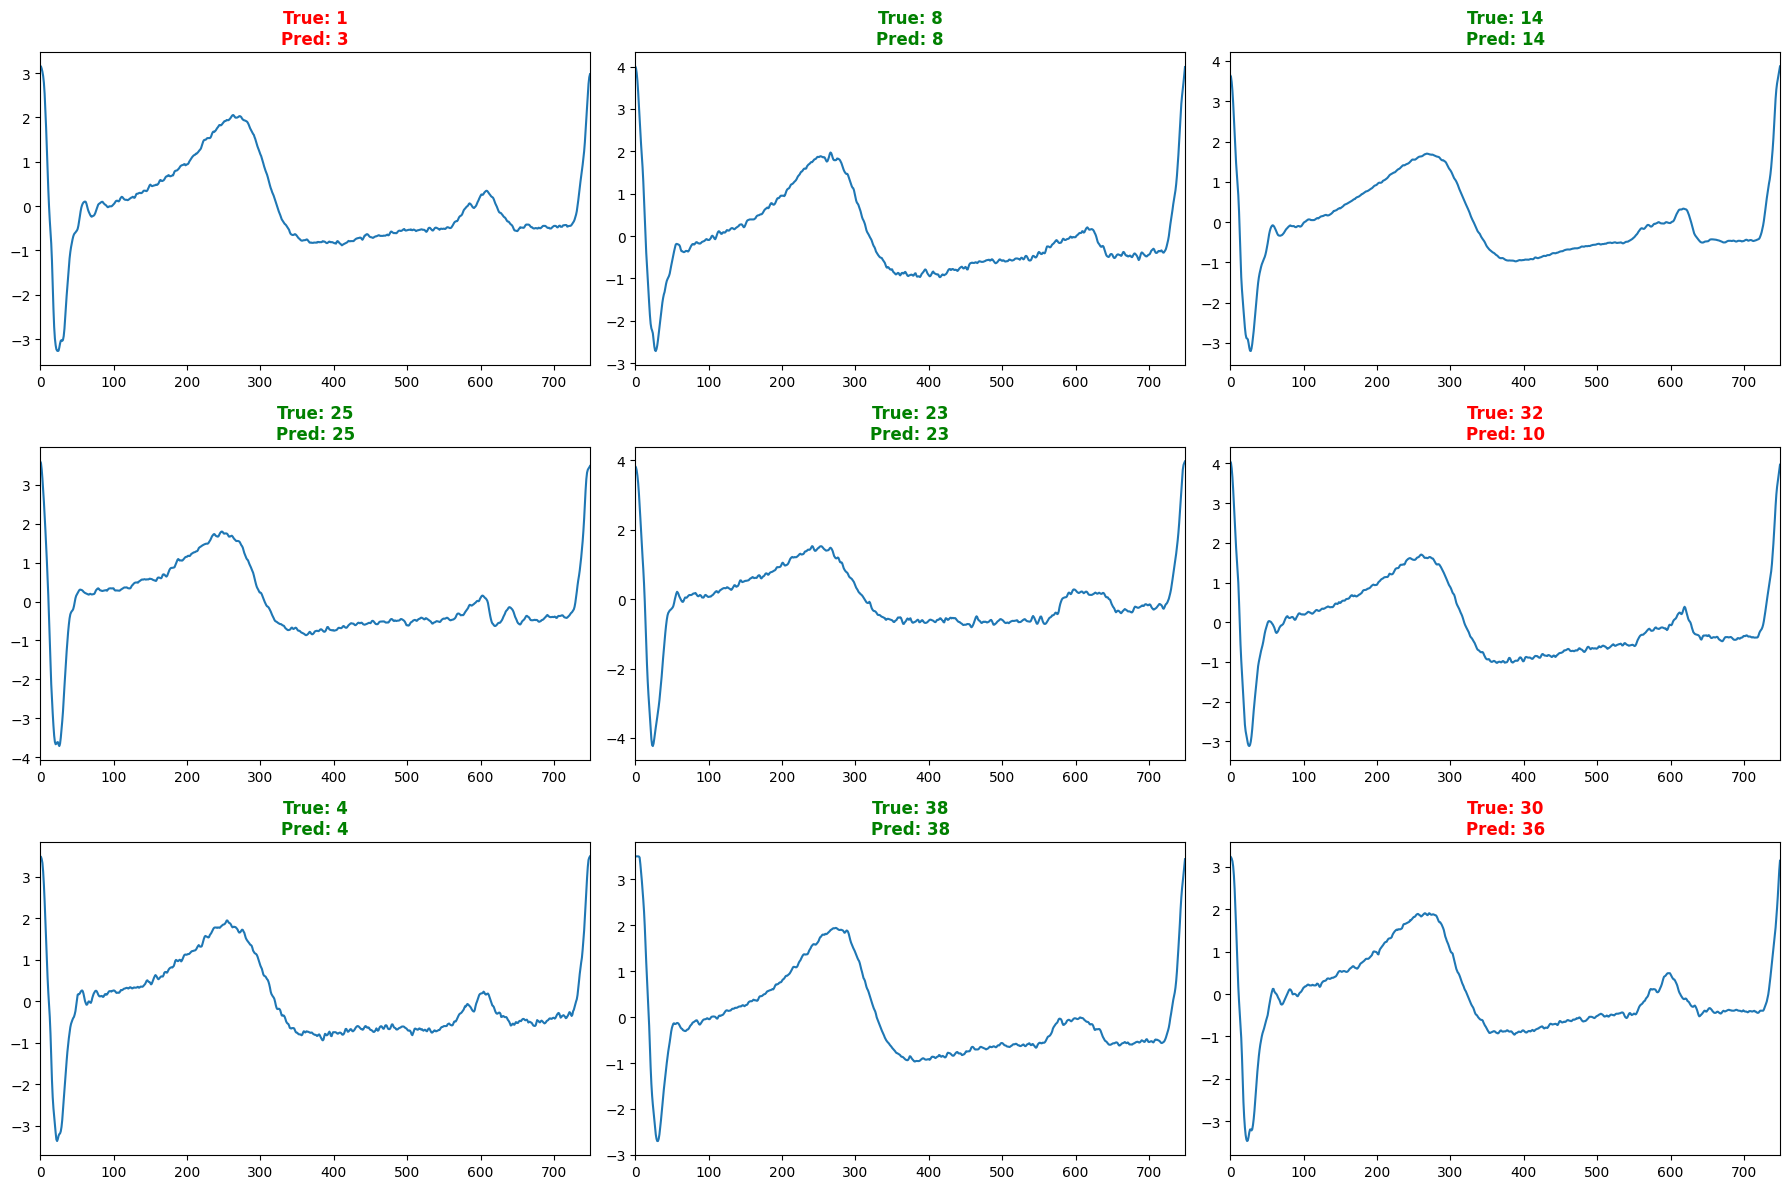

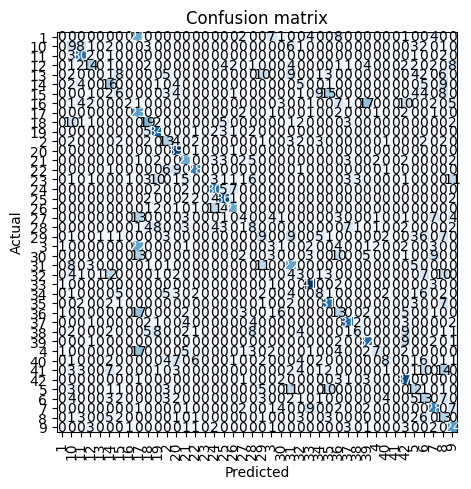

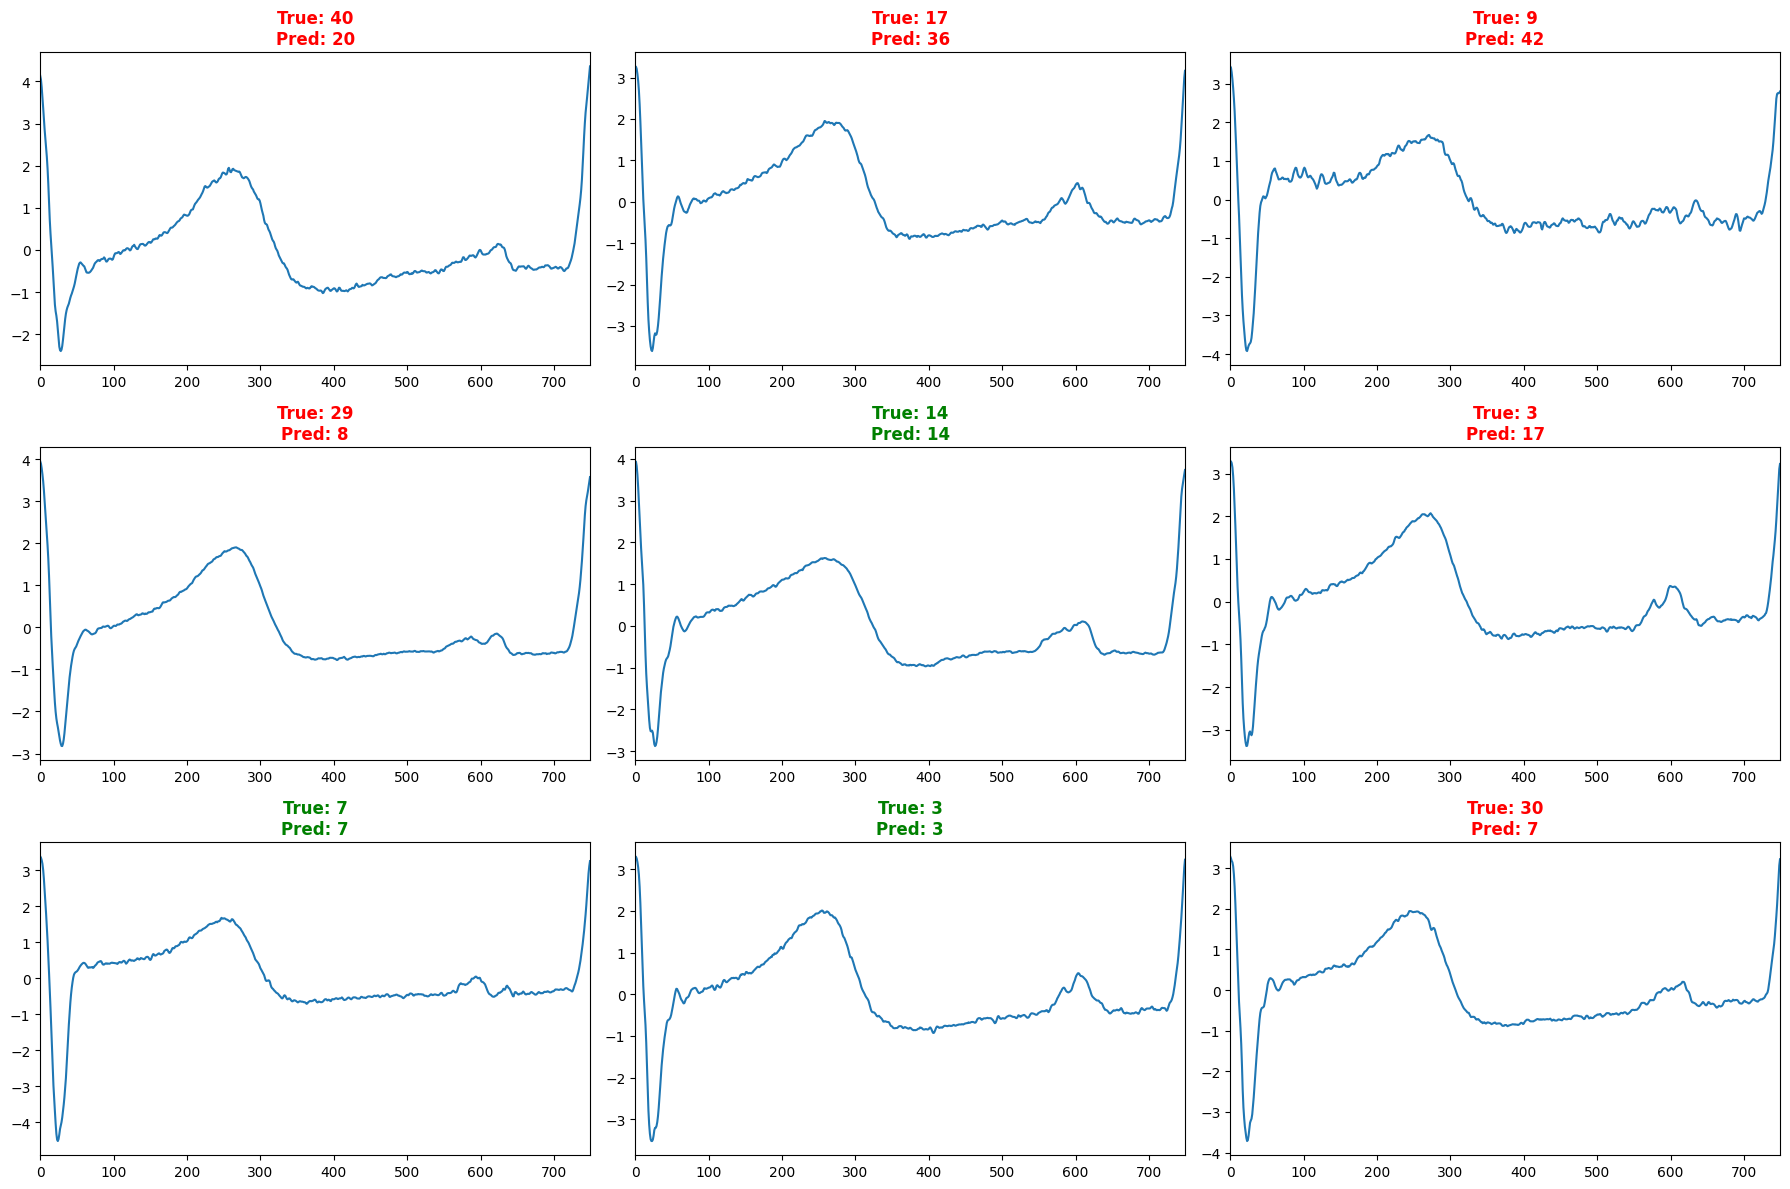

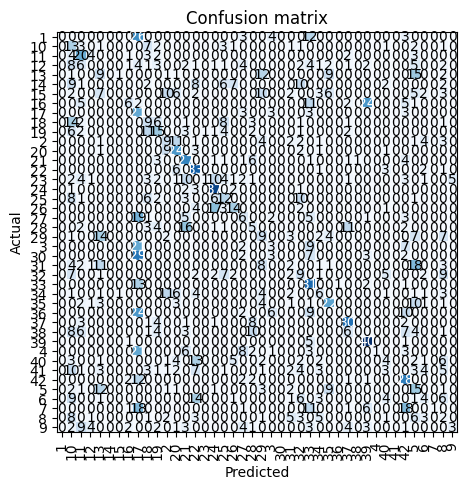

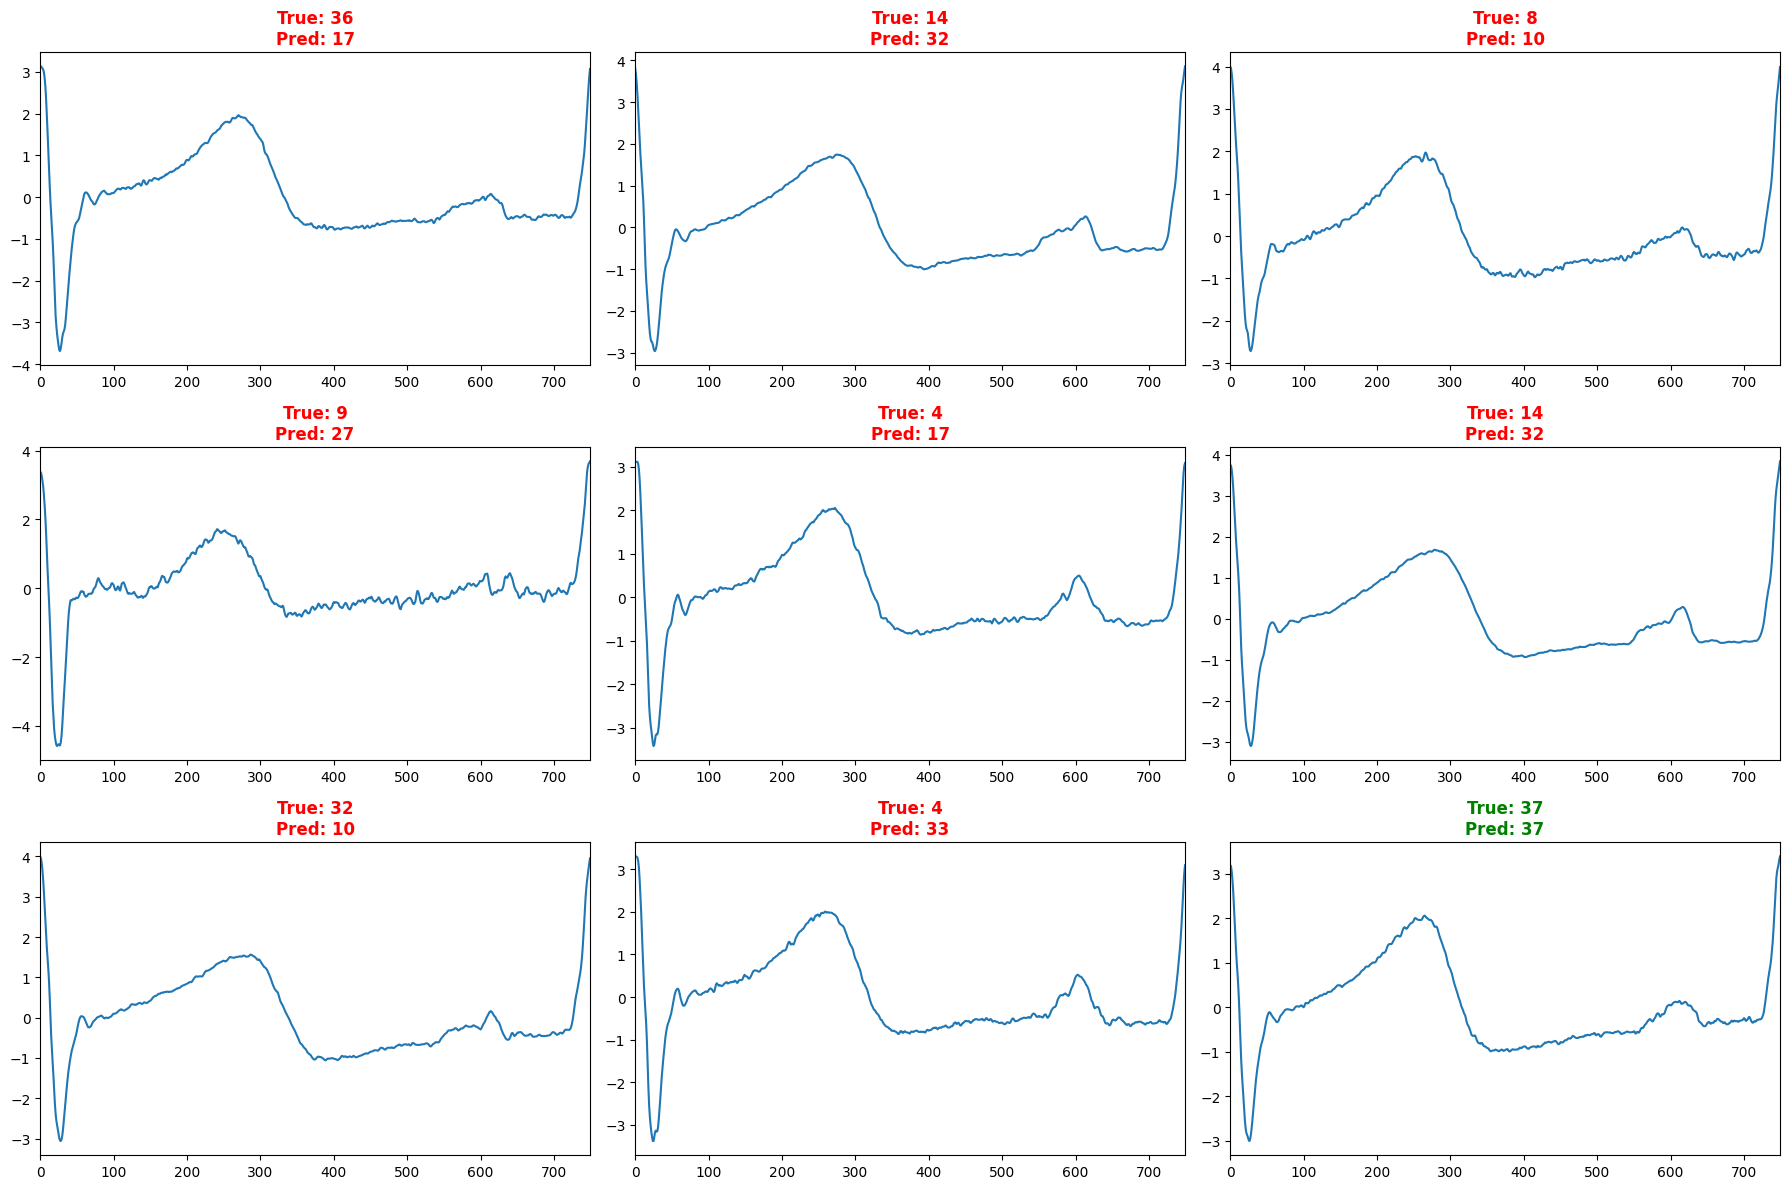

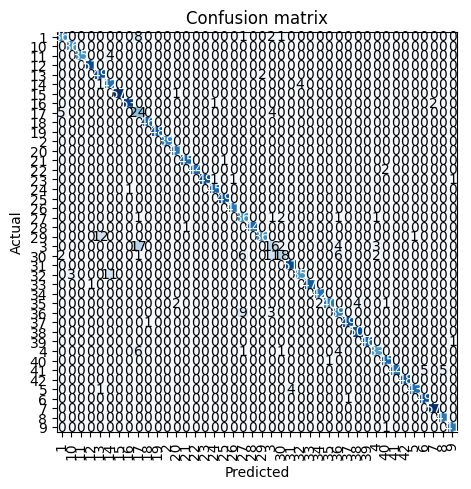

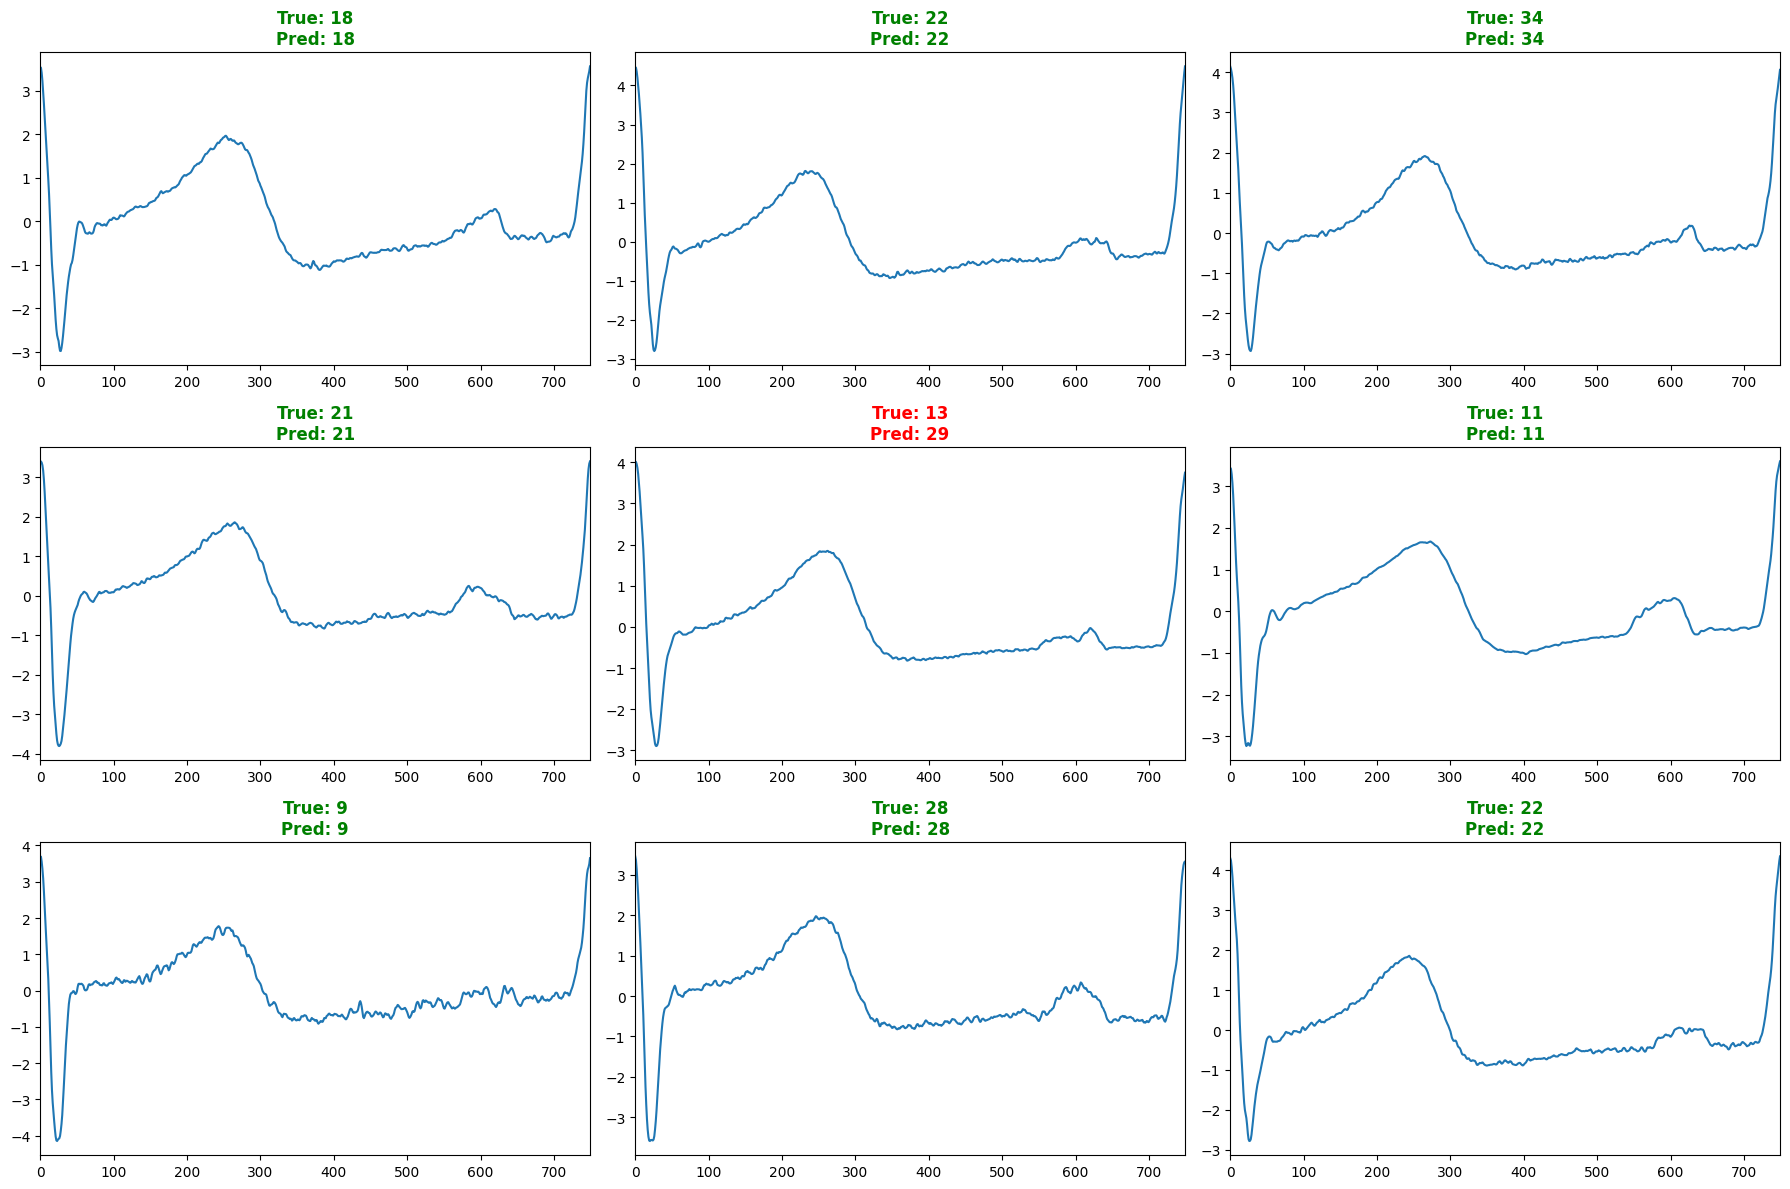

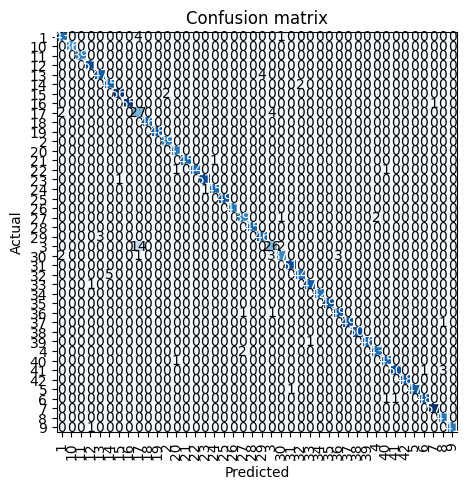

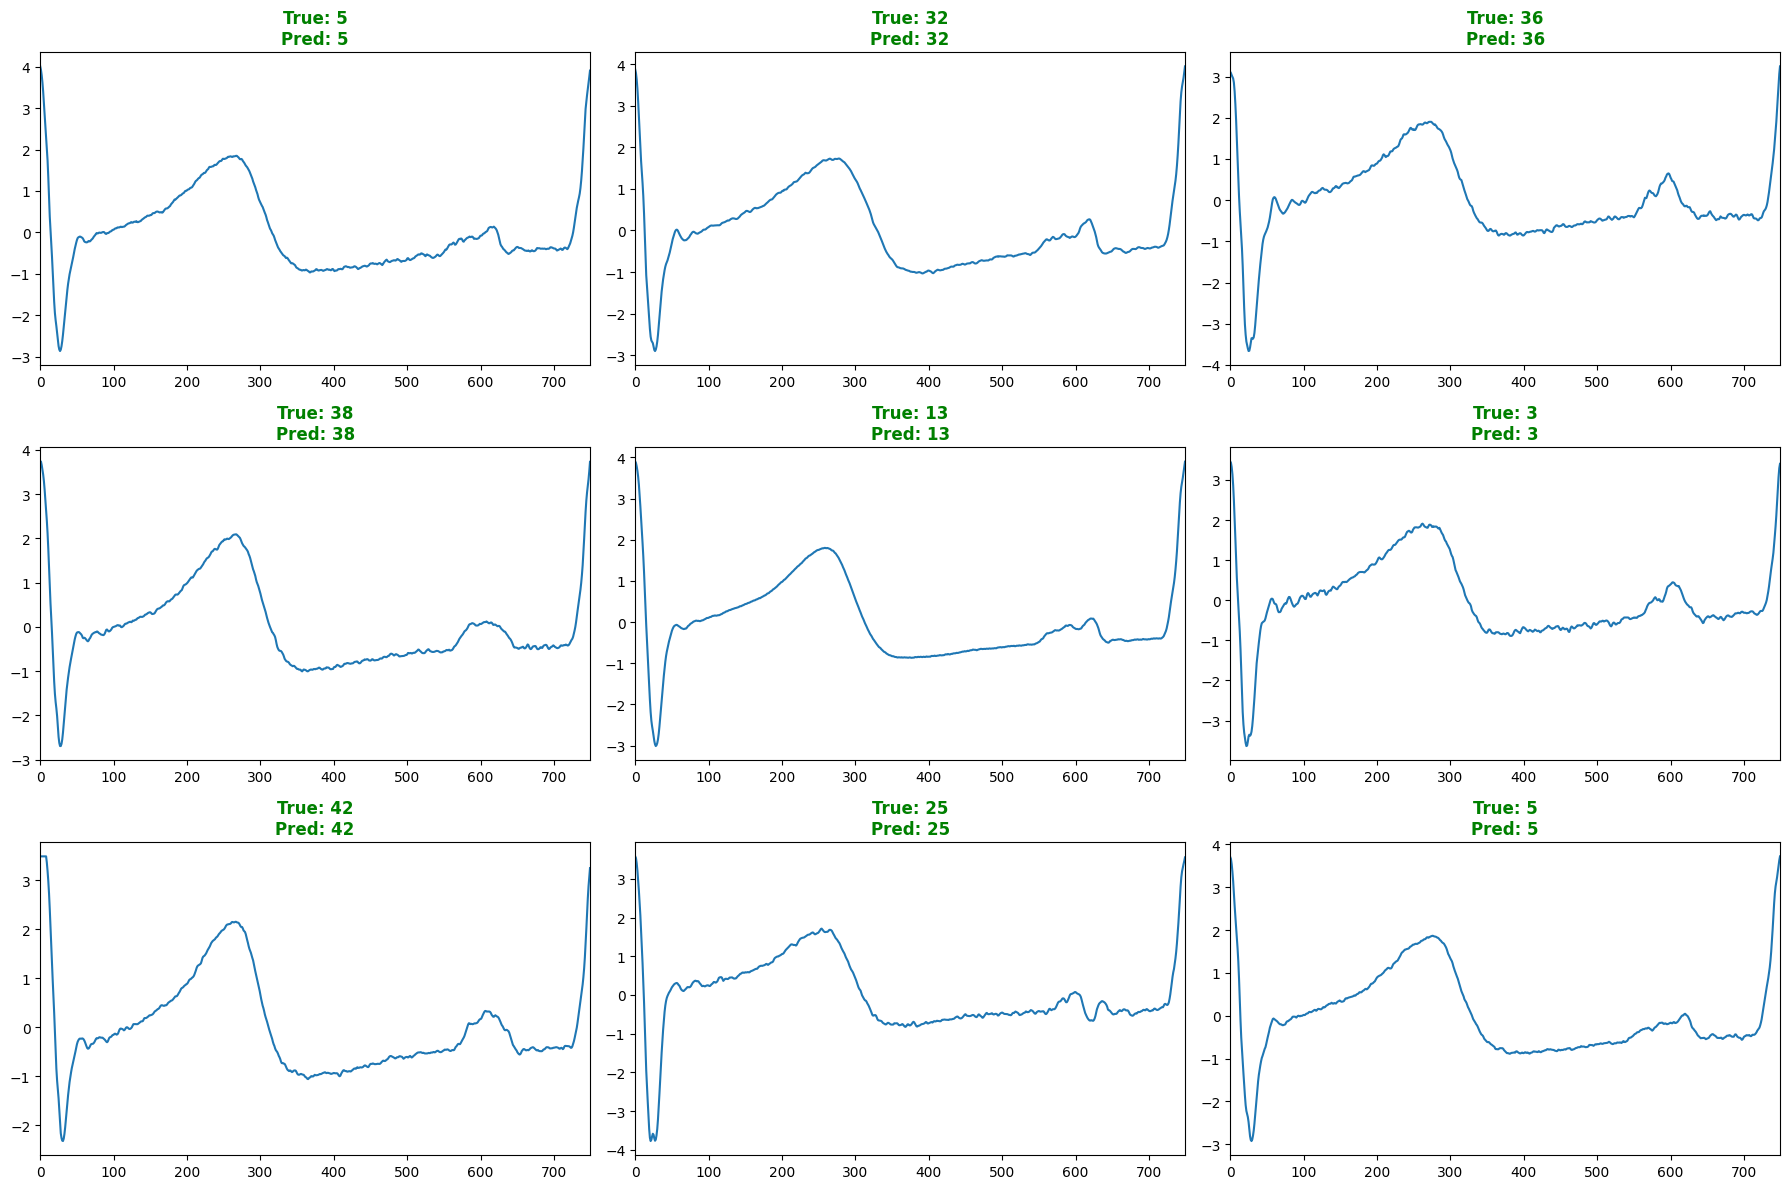

In [14]:

dsid = 'NonInvasiveFetalECGThorax1'
bs = 64
X, y, splits = get_UCR_data(dsid, return_split=False)
print(X.shape)
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])

archs = [ (FCN, {}),
        (LSTM, {}),
        (RNN, {}),
        (LSTM_FCN, {}), (InceptionTime, {})
      ]

results = pd.DataFrame(columns=['arch', 'hyperparams', 'train loss', 'valid loss', 'accuracy', ])
for i, (arch, k) in enumerate(archs):
    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    learn = Learner(dls, model,  metrics=accuracy)

    # On commence l'entrainement
    learn.fit_one_cycle(100, 1e-3)

    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, vals[0], vals[1], vals[2]]
    #on sauvegarde les resultats

    # Matrice fe confusion
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix()
    cm_filename = f"{arch.__name__}_confusion_matrix.jpeg"
    plt.savefig(cm_filename)

    # Graphe de prediction
    learn.show_results()
    plt.savefig(f"{arch.__name__}_predictions.png")
    results.sort_values(by='accuracy', ascending=False, kind='stable', ignore_index=True, inplace=True)
    clear_output()
    display(results)